In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import math
import glob

from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau

import sklearn 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay

import HigherTierModel

In [2]:
###########################################################
# Define file
###########################################################

# Get training file
trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_*.npz')
print(trainFileNames)

['/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_1.npz', '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_0.npz']


In [3]:
###########################################################
# Hyperparameters
###########################################################

nEpochs = 10
batchSize = 64
learningRate = 1e-3

In [4]:
###########################################################
# Get data from file
###########################################################

# Variables
variables_train = np.empty((0, 12))
variables_test = np.empty((0, 12))

# Truth
y_train = np.empty((0, 1))
y_test = np.empty((0, 1))

for trainFileName in trainFileNames :
    print('Reading file: ', str(trainFileName),', This may take a while...')
    
    data = np.load(trainFileName)

    # Variables
    variables_train = np.concatenate((variables_train, data['variables_train']), axis=0)
    variables_test = np.concatenate((variables_test, data['variables_test']), axis=0)
    # Truth
    y_train = np.concatenate((y_train, data['y_train']), axis=0)
    y_test = np.concatenate((y_test, data['y_test']), axis=0)

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('y_train.shape:', y_train.shape)
print('y_test.shape:', y_test.shape)

nVariables = variables_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_1.npz , This may take a while...
Reading file:  /Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/ccnutree_0.npz , This may take a while...
variables_train.shape: (1632371, 12)
variables_test.shape: (181374, 12)
y_train.shape: (1632371, 1)
y_test.shape: (181374, 1)


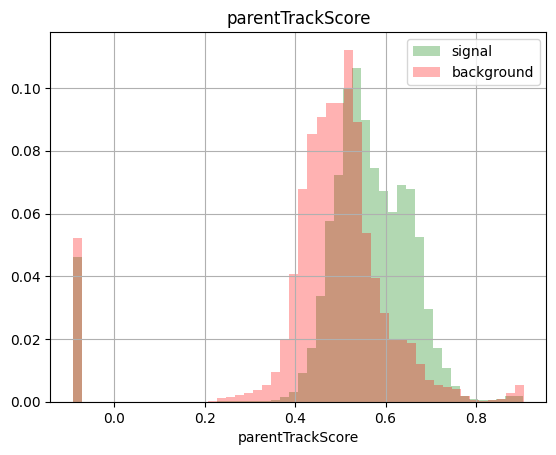

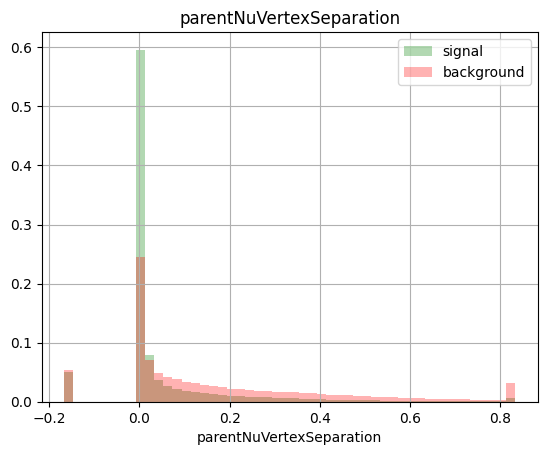

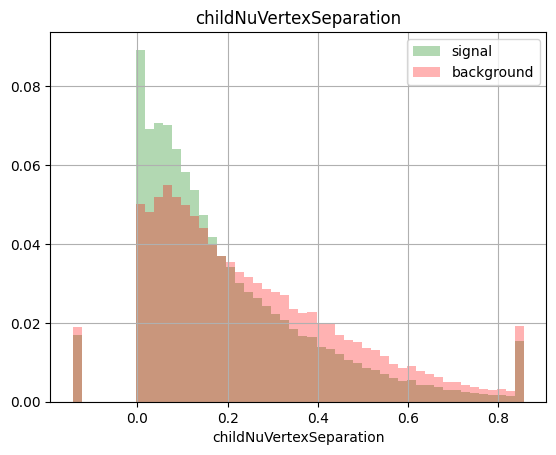

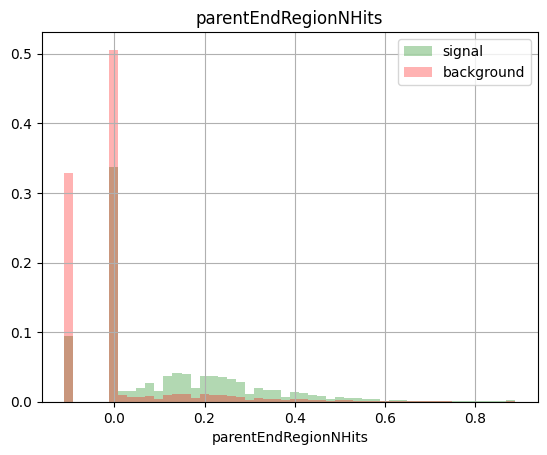

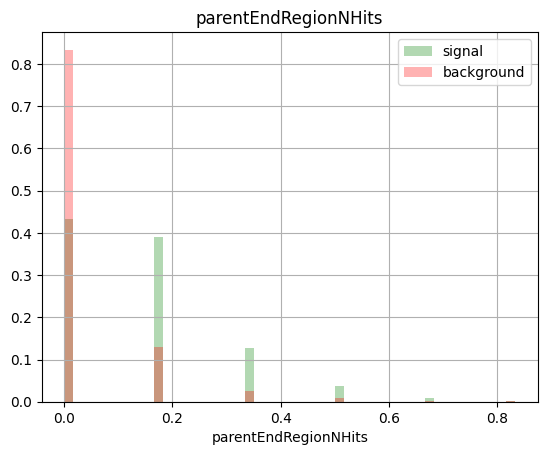

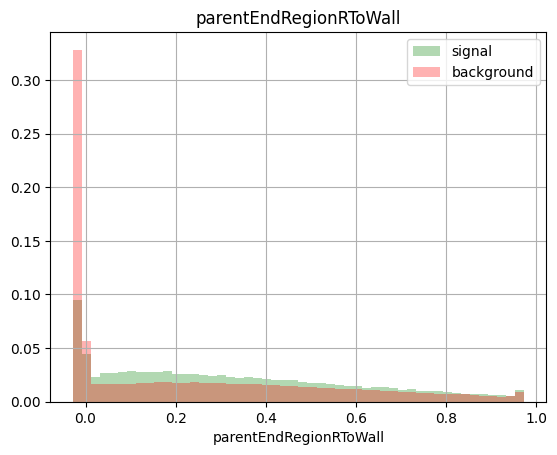

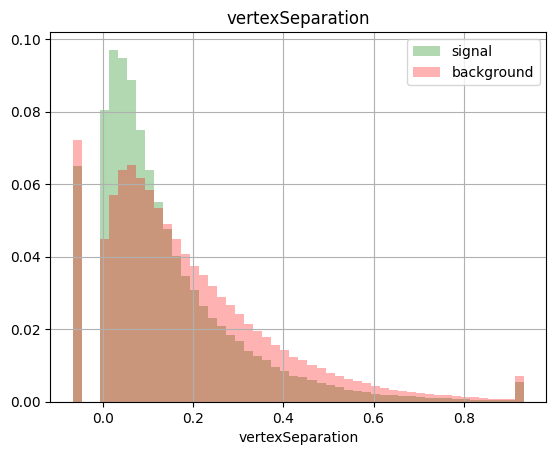

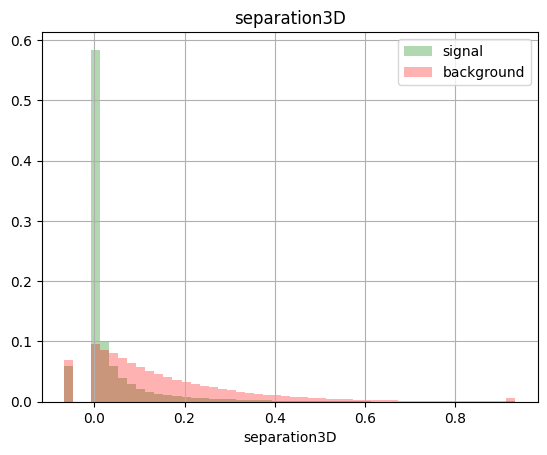

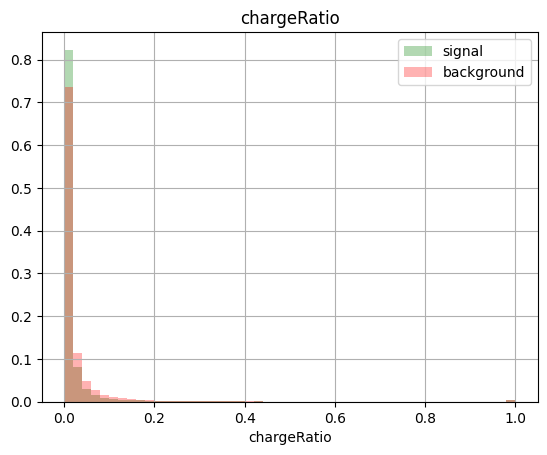

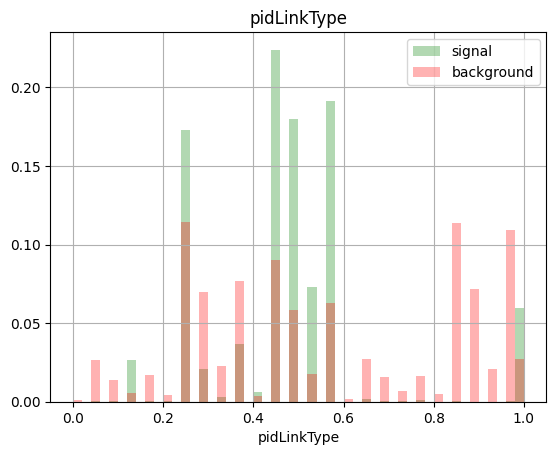

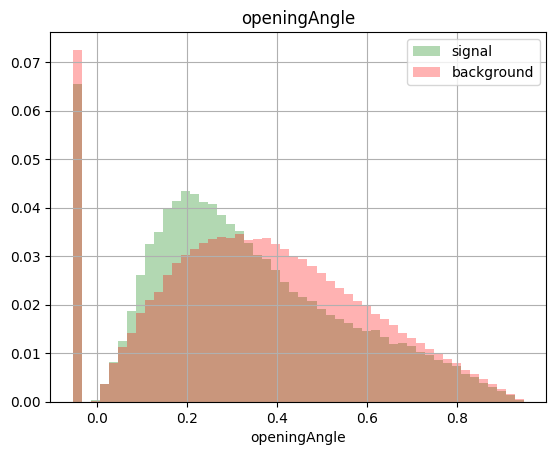

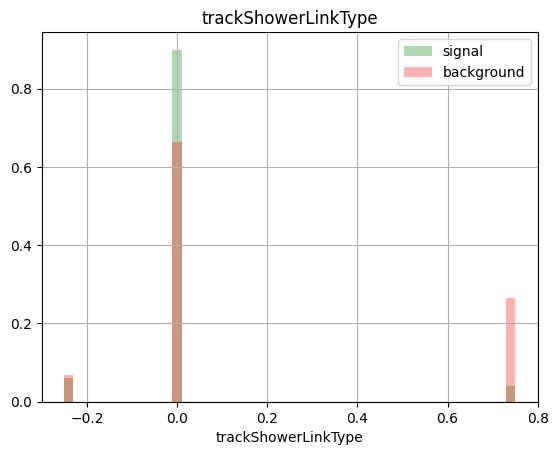

In [5]:
###########################################################
# Plot variables
###########################################################

# 0-parentTrackScore
# 1-parentNuVertexSeparation
# 2-childNuVertexSeparation
# 3-parentEndRegionNHits
# 4-parentEndRegionNParticles
# 5-parentEndRegionRToWall
# 6-vertexSeparation
# 7-separation3D
# 8-chargeRatio
# 9-pidLinkType
# 10-openingAngle
# 11-trackShowerLinkType

def normaliseXAxis(variable, minLimit, maxLimit) :
    
    interval = math.fabs(minLimit) + math.fabs(maxLimit)
    variable[variable < 0] = minLimit
    variable[variable > maxLimit] = maxLimit
    variable /= interval
    
def drawSignalBackground(variable, truth_labels, graph_label) :
    
    signal_mask_vis = (y_train == 1).reshape(-1)
    background_mask_vis = (y_train == 0).reshape(-1)

    variable_signal = variable[signal_mask_vis]
    variable_background = variable[background_mask_vis]
        
        
    signal_weights = 1.0 / float(variable_signal.shape[0])
    signal_weights = np.ones(variable_signal.shape[0]) * signal_weights

    background_weights = 1.0 / float(variable_background.shape[0])
    background_weights = np.ones(variable_background.shape[0]) * background_weights   
        
        
    plt.hist(variable_signal, bins=50, alpha=0.3, color='green', weights=signal_weights, label='signal')
    plt.hist(variable_background, bins=50, alpha=0.3, color='red', weights=background_weights, label='background')
    plt.title(graph_label)
    plt.xlabel(graph_label)
    plt.legend()
    plt.grid(True)
    plt.show()   

    
##############
# 0-parentTrackScore

parentTrackScore_min = -0.1
parentTrackScore_max = 1.0

parentTrackScore_vis = np.array(variables_train[:,0])

normaliseXAxis(parentTrackScore_vis,parentTrackScore_min, parentTrackScore_max)
drawSignalBackground(parentTrackScore_vis, y_train, "parentTrackScore")

    
##############
# 1-parentNuVertexSeparation

parentNuVertexSeparation_min = -100
parentNuVertexSeparation_max = 500

parentNuVertexSeparation_vis = np.array(variables_train[:,1])

normaliseXAxis(parentNuVertexSeparation_vis, parentNuVertexSeparation_min, parentNuVertexSeparation_max)
drawSignalBackground(parentNuVertexSeparation_vis, y_train, "parentNuVertexSeparation")


##############
# 2-childNuVertexSeparation

childNuVertexSeparation_min = -100
childNuVertexSeparation_max = 600

childNuVertexSeparation_vis = np.array(variables_train[:,2])

normaliseXAxis(childNuVertexSeparation_vis, childNuVertexSeparation_min, childNuVertexSeparation_max)
drawSignalBackground(childNuVertexSeparation_vis, y_train, "childNuVertexSeparation")

##############
# 3-parentEndRegionNHits

parentEndRegionNHits_min = -10
parentEndRegionNHits_max = 80

parentEndRegionNHits_vis = np.array(variables_train[:,3])

normaliseXAxis(parentEndRegionNHits_vis, parentEndRegionNHits_min, parentEndRegionNHits_max)
drawSignalBackground(parentEndRegionNHits_vis, y_train, "parentEndRegionNHits")

##############
# 4-parentEndRegionNParticles

parentEndRegionNParticles_min = -1
parentEndRegionNParticles_max = 5

parentEndRegionNParticles_vis = np.array(variables_train[:,4])

normaliseXAxis(parentEndRegionNParticles_vis, parentEndRegionNParticles_min, parentEndRegionNParticles_max)
drawSignalBackground(parentEndRegionNParticles_vis, y_train, "parentEndRegionNHits")

##############
# 5-parentEndRegionRToWall

parentEndRegionRToWall_min = -10
parentEndRegionRToWall_max = 350

parentEndRegionRToWall_vis = np.array(variables_train[:,5])

normaliseXAxis(parentEndRegionRToWall_vis, parentEndRegionRToWall_min, parentEndRegionRToWall_max)
drawSignalBackground(parentEndRegionRToWall_vis, y_train, "parentEndRegionRToWall")

##############
# 6-vertexSeparation

vertexSeparation_min = -50
vertexSeparation_max = 700

vertexSeparation_vis = np.array(variables_train[:,6])

normaliseXAxis(vertexSeparation_vis, vertexSeparation_min, vertexSeparation_max)
drawSignalBackground(vertexSeparation_vis, y_train, "vertexSeparation")

##############
# 7-separation3D

separation3D_min = -50
separation3D_max = 700

separation3D_vis = np.array(variables_train[:,7])

normaliseXAxis(separation3D_vis, separation3D_min, separation3D_max)
drawSignalBackground(separation3D_vis, y_train, "separation3D")

##############
# 8-chargeRatio

chargeRatio_min = 0
chargeRatio_max = 100

chargeRatio_vis = np.array(variables_train[:,8])

normaliseXAxis(chargeRatio_vis, chargeRatio_min, chargeRatio_max)
drawSignalBackground(chargeRatio_vis, y_train, "chargeRatio")

##############
# 9-pidLinkType

pidLinkType_min = 0
pidLinkType_max = 25

pidLinkType_vis = np.array(variables_train[:,9])

normaliseXAxis(pidLinkType_vis, pidLinkType_min, pidLinkType_max)
drawSignalBackground(pidLinkType_vis, y_train, "pidLinkType")

##############
# 10-openingAngle

openingAngle_min = -10
openingAngle_max = 180

openingAngle_vis = np.array(variables_train[:,10])

normaliseXAxis(openingAngle_vis, openingAngle_min, openingAngle_max)
drawSignalBackground(openingAngle_vis, y_train, "openingAngle")

##############
# 10-trackShowerLinkType

trackShowerLinkType_min = -1
trackShowerLinkType_max = 3

trackShowerLinkType_vis = np.array(variables_train[:,11])

normaliseXAxis(trackShowerLinkType_vis, trackShowerLinkType_min, trackShowerLinkType_max)
drawSignalBackground(trackShowerLinkType_vis, y_train, "trackShowerLinkType")

In [6]:
###########################################################
# Normalise variables
###########################################################

###########
# Train
###########
# Pull out of container
parentTrackScore_norm_train = np.array(variables_train[:,0])
parentNuVertexSeparation_norm_train = np.array(variables_train[:,1])
childNuVertexSeparation_norm_train = np.array(variables_train[:,2])
parentEndRegionNHits_norm_train = np.array(variables_train[:,3])
parentEndRegionNParticles_norm_train = np.array(variables_train[:,4])
parentEndRegionRToWall_norm_train = np.array(variables_train[:,5])
vertexSeparation_norm_train = np.array(variables_train[:,6])
separation3D_norm_train = np.array(variables_train[:,7])
chargeRatio_norm_train = np.array(variables_train[:,8])
pidLinkType_norm_train = np.array(variables_train[:,9])
openingAngle_norm_train =  np.array(variables_train[:,10])
trackShowerLinkType_norm_train = np.array(variables_train[:,11])

# Normalise
normaliseXAxis(parentTrackScore_norm_train, parentTrackScore_min, parentTrackScore_max)
normaliseXAxis(parentNuVertexSeparation_norm_train, parentNuVertexSeparation_min, parentNuVertexSeparation_max)
normaliseXAxis(childNuVertexSeparation_norm_train, childNuVertexSeparation_min, childNuVertexSeparation_max)
normaliseXAxis(parentEndRegionNHits_norm_train, parentEndRegionNHits_min, parentEndRegionNHits_max)
normaliseXAxis(parentEndRegionNParticles_norm_train, parentEndRegionNParticles_min, parentEndRegionNParticles_max)
normaliseXAxis(parentEndRegionRToWall_norm_train, parentEndRegionRToWall_min, parentEndRegionRToWall_max)
normaliseXAxis(vertexSeparation_norm_train, vertexSeparation_min, vertexSeparation_max)
normaliseXAxis(separation3D_norm_train, separation3D_min, separation3D_max)
normaliseXAxis(chargeRatio_norm_train, chargeRatio_min, chargeRatio_max)
normaliseXAxis(pidLinkType_norm_train, pidLinkType_min, pidLinkType_max)
normaliseXAxis(openingAngle_norm_train, openingAngle_min, openingAngle_max)
normaliseXAxis(trackShowerLinkType_norm_train, trackShowerLinkType_min, trackShowerLinkType_max)

# Reshape
parentTrackScore_norm_train = parentTrackScore_norm_train.reshape(-1,1)
parentNuVertexSeparation_norm_train = parentNuVertexSeparation_norm_train.reshape(-1,1)
childNuVertexSeparation_norm_train = childNuVertexSeparation_norm_train.reshape(-1,1)
parentEndRegionNHits_norm_train = parentEndRegionNHits_norm_train.reshape(-1,1)
parentEndRegionNParticles_norm_train = parentEndRegionNParticles_norm_train.reshape(-1,1)
parentEndRegionRToWall_norm_train = parentEndRegionRToWall_norm_train.reshape(-1,1)
vertexSeparation_norm_train = vertexSeparation_norm_train.reshape(-1,1)
separation3D_norm_train = separation3D_norm_train.reshape(-1,1)
chargeRatio_norm_train = chargeRatio_norm_train.reshape(-1,1)
pidLinkType_norm_train = pidLinkType_norm_train.reshape(-1,1)
openingAngle_norm_train = openingAngle_norm_train.reshape(-1,1)
trackShowerLinkType_norm_train = trackShowerLinkType_norm_train.reshape(-1,1)

# Combine
variables_train = np.concatenate((parentTrackScore_norm_train, parentNuVertexSeparation_norm_train, childNuVertexSeparation_norm_train, parentEndRegionNHits_norm_train, \
                                  parentEndRegionNParticles_norm_train, parentEndRegionRToWall_norm_train, vertexSeparation_norm_train, separation3D_norm_train, chargeRatio_norm_train, \
                                  pidLinkType_norm_train, openingAngle_norm_train, trackShowerLinkType_norm_train), axis=1)

###########
# Test
###########
# Pull out of container
parentTrackScore_norm_test = np.array(variables_test[:,0])
parentNuVertexSeparation_norm_test = np.array(variables_test[:,1])
childNuVertexSeparation_norm_test = np.array(variables_test[:,2])
parentEndRegionNHits_norm_test = np.array(variables_test[:,3])
parentEndRegionNParticles_norm_test = np.array(variables_test[:,4])
parentEndRegionRToWall_norm_test = np.array(variables_test[:,5])
vertexSeparation_norm_test = np.array(variables_test[:,6])
separation3D_norm_test = np.array(variables_test[:,7])
chargeRatio_norm_test = np.array(variables_test[:,8])
pidLinkType_norm_test = np.array(variables_test[:,9])
openingAngle_norm_test =  np.array(variables_test[:,10])
trackShowerLinkType_norm_test = np.array(variables_test[:,11])

# Normalise
normaliseXAxis(parentTrackScore_norm_test, parentTrackScore_min, parentTrackScore_max)
normaliseXAxis(parentNuVertexSeparation_norm_test, parentNuVertexSeparation_min, parentNuVertexSeparation_max)
normaliseXAxis(childNuVertexSeparation_norm_test, childNuVertexSeparation_min, childNuVertexSeparation_max)
normaliseXAxis(parentEndRegionNHits_norm_test, parentEndRegionNHits_min, parentEndRegionNHits_max)
normaliseXAxis(parentEndRegionNParticles_norm_test, parentEndRegionNParticles_min, parentEndRegionNParticles_max)
normaliseXAxis(parentEndRegionRToWall_norm_test, parentEndRegionRToWall_min, parentEndRegionRToWall_max)
normaliseXAxis(vertexSeparation_norm_test, vertexSeparation_min, vertexSeparation_max)
normaliseXAxis(separation3D_norm_test, separation3D_min, separation3D_max)
normaliseXAxis(chargeRatio_norm_test, chargeRatio_min, chargeRatio_max)
normaliseXAxis(pidLinkType_norm_test, pidLinkType_min, pidLinkType_max)
normaliseXAxis(openingAngle_norm_test, openingAngle_min, openingAngle_max)
normaliseXAxis(trackShowerLinkType_norm_test, trackShowerLinkType_min, trackShowerLinkType_max)

# Reshape
parentTrackScore_norm_test = parentTrackScore_norm_test.reshape(-1,1)
parentNuVertexSeparation_norm_test = parentNuVertexSeparation_norm_test.reshape(-1,1)
childNuVertexSeparation_norm_test = childNuVertexSeparation_norm_test.reshape(-1,1)
parentEndRegionNHits_norm_test = parentEndRegionNHits_norm_test.reshape(-1,1)
parentEndRegionNParticles_norm_test = parentEndRegionNParticles_norm_test.reshape(-1,1)
parentEndRegionRToWall_norm_test = parentEndRegionRToWall_norm_test.reshape(-1,1)
vertexSeparation_norm_test = vertexSeparation_norm_test.reshape(-1,1)
separation3D_norm_test = separation3D_norm_test.reshape(-1,1)
chargeRatio_norm_test = chargeRatio_norm_test.reshape(-1,1)
pidLinkType_norm_test = pidLinkType_norm_test.reshape(-1,1)
openingAngle_norm_test = openingAngle_norm_test.reshape(-1,1)
trackShowerLinkType_norm_test = trackShowerLinkType_norm_test.reshape(-1,1)

# Combine
variables_test = np.concatenate((parentTrackScore_norm_test, parentNuVertexSeparation_norm_test, childNuVertexSeparation_norm_test, parentEndRegionNHits_norm_test, \
                                 parentEndRegionNParticles_norm_test, parentEndRegionRToWall_norm_test, vertexSeparation_norm_test, separation3D_norm_test, chargeRatio_norm_test, \
                                 pidLinkType_norm_test, openingAngle_norm_test, trackShowerLinkType_norm_test), axis=1)

In [7]:
###########################################################
# Define model
###########################################################

model = HigherTierModel.HigherTierModel(nVariables)

In [8]:
###########################################################
# Class weights?
###########################################################

nFalse = np.count_nonzero(y_train == 0)    
nTrue = np.count_nonzero(y_train == 1)  

# Normalise to largest
maxLinks = max(nFalse, nTrue)

classWeights = {0: maxLinks/nFalse, 1: maxLinks/nTrue}

print('classWeights:', classWeights)

classWeights: {0: 1.0, 1: 8.853861570222989}


In [9]:
###########################################################
# Define the optimiser and compile the model
###########################################################

optimiser = optimizers.legacy.Adam(learning_rate=learningRate)
model.compile(loss='binary_crossentropy', optimizer=optimiser, metrics=['accuracy'])

In [10]:
###########################################################
# Fit the model
###########################################################

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, verbose=1)

history = model.fit(variables_train, y_train, validation_data=(variables_test, y_test), batch_size=batchSize, shuffle=True, epochs=nEpochs, class_weight=classWeights) 

Epoch 1/10
25506/25506 [==============================] - 17s 676us/step - loss: 0.6517 - accuracy: 0.8468 - val_loss: 0.3034 - val_accuracy: 0.8724
Epoch 2/10
25506/25506 [==============================] - 17s 656us/step - loss: 0.5981 - accuracy: 0.8595 - val_loss: 0.2935 - val_accuracy: 0.8701
Epoch 3/10
25506/25506 [==============================] - 16s 647us/step - loss: 0.5869 - accuracy: 0.8608 - val_loss: 0.2850 - val_accuracy: 0.8776
Epoch 4/10
25506/25506 [==============================] - 16s 646us/step - loss: 0.5806 - accuracy: 0.8617 - val_loss: 0.2814 - val_accuracy: 0.8703
Epoch 5/10
25506/25506 [==============================] - 16s 646us/step - loss: 0.5744 - accuracy: 0.8620 - val_loss: 0.2737 - val_accuracy: 0.8777
Epoch 6/10
25506/25506 [==============================] - 16s 646us/step - loss: 0.5700 - accuracy: 0.8631 - val_loss: 0.2557 - val_accuracy: 0.8907
Epoch 7/10
25506/25506 [==============================] - 17s 649us/step - loss: 0.5668 - accuracy: 0.8636

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


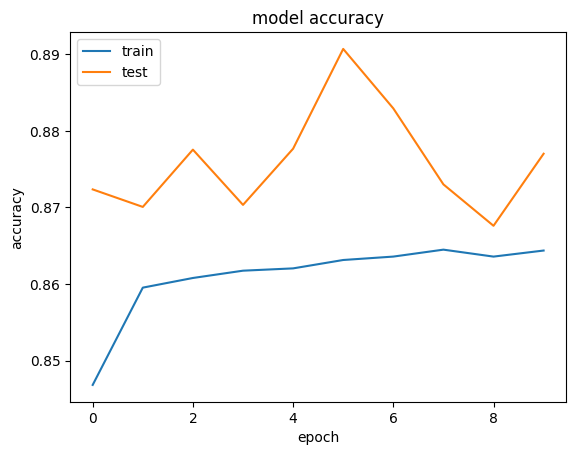

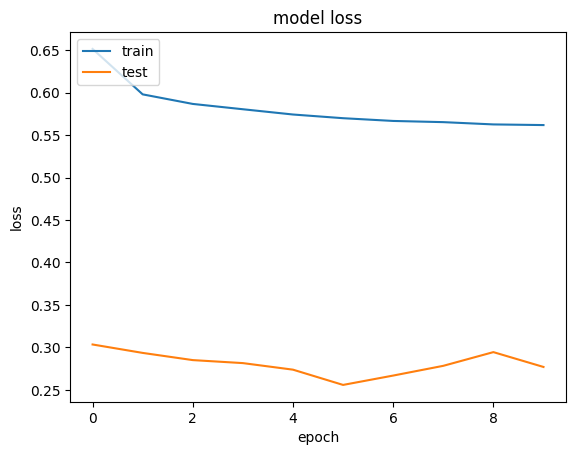

In [11]:
###########################################################
# Evaluate training
###########################################################

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
###########################################################
# Evaluate the test sample
###########################################################

y_pred = model.predict(variables_test)


5668/5668 [==============================] - 1s 256us/step


In [13]:
#######################################
# Some functions to evaluate performance
#######################################

def calculate_accuracy(scores, true_labels):
    
    scores = scores.reshape(-1)
    true_labels = true_labels.reshape(-1)
    
    true_edge_mask = (true_labels == 1)
    false_edge_mask = (true_labels == 0)
    
    true_edge_scores = scores[true_edge_mask]
    false_edge_scores = scores[false_edge_mask]
    
    thresholds = np.arange(0.05, 1.0, 0.05)
    predictions = []
    accuracy = []
    efficiency = []
    metric = []
    purity = []

    for threshold in thresholds:
        prediction = np.array(scores >= threshold, dtype='float')
        true_edge_prediction_count = np.count_nonzero(true_edge_scores >= threshold)
        false_edge_prediction_count = np.count_nonzero(false_edge_scores >= threshold)
        
        this_efficiency = float(true_edge_prediction_count) / float(true_edge_scores.shape[0])
        this_purity = float(true_edge_prediction_count) / float(true_edge_prediction_count + false_edge_prediction_count) 
        
        accuracy.append(accuracy_score(true_labels, prediction))
        efficiency.append(this_efficiency)
        purity.append(this_purity)
        metric.append(this_efficiency * this_purity)

    accuracy = np.array(accuracy)
    efficiency = np.array(efficiency)
    purity = np.array(purity)
    metric = np.array(metric)
    
    plt.clf()
    plt.scatter(thresholds, accuracy, color='blue', label='accuracy', s=10)
    plt.plot(thresholds, accuracy, color='blue')
    plt.scatter(thresholds, efficiency, color='red', label='efficiency', s=10)
    plt.plot(thresholds, efficiency, color='red')
    plt.scatter(thresholds, purity, color='green', label='purity', s=10)
    plt.plot(thresholds, purity, color='green')
    plt.scatter(thresholds, metric, color='violet', label='efficiency*purity', s=10)
    plt.plot(thresholds, metric, color='violet')
    
    plt.xlabel('threshold')
    plt.ylabel('arbitary units')
    plt.legend()
    plt.show()
        
    max_accuracy = np.max(accuracy)
    max_accuracy_index = np.argmax(accuracy)
    optimal_threshold_accuracy = thresholds[max_accuracy_index].item()

    max_metric = np.max(metric)
    max_metric_index = np.argmax(metric)
    optimal_threshold_metric = thresholds[max_metric_index].item()    
    
    return optimal_threshold_accuracy, max_accuracy, optimal_threshold_metric, max_metric

def plot_scores(scores, true_labels):
    
    true_edge_mask = (true_labels == 1).reshape(-1)
    false_edge_mask = (true_labels == 0).reshape(-1)
    
    true_edge_scores = scores[true_edge_mask]
    false_edge_scores = scores[false_edge_mask]
    
    pos_plotting_weights = 1.0 / float(true_edge_scores.shape[0])
    pos_plotting_weights = np.ones(true_edge_scores.shape[0]) * pos_plotting_weights
    neg_plotting_weights = 1.0 / float(false_edge_scores.shape[0])
    neg_plotting_weights = np.ones(false_edge_scores.shape[0]) * neg_plotting_weights
    
    plt.figure()
    plt.hist(true_edge_scores, bins=50, range=(0, 1.1), alpha=0.3, color='blue', edgecolor='black', label='true_edge_scores', weights=pos_plotting_weights)
    plt.hist(false_edge_scores, bins=50, range=(0, 1.1), alpha=0.3, color='red', edgecolor='black', label='false_edge_scores', weights=neg_plotting_weights)

    #plt.yscale('log')
    #plt.title(train_or_test)
    plt.legend()
    plt.show()    
    
    
def draw_confusion(scores, true_labels):
    
    # Need to redefine things to get them in the correct format for confusion matrix viewing
    nClasses = 2
    
    redefined_true_labels = to_categorical(true_labels, nClasses) # [false, true]
    trueProb = scores # prob that true
    falseProb = 1 - scores # prob that false
    redefined_scores = np.concatenate((falseProb, trueProb), axis=1)

    # Building the confusion matrix
    
    print(redefined_true_labels.argmax(axis=1))
    
    confMatrix = confusion_matrix(redefined_true_labels.argmax(axis=1), redefined_scores.argmax(axis=1))

    trueSums = np.sum(confMatrix, axis=1)
    predSums = np.sum(confMatrix, axis=0)

    trueNormalised = np.zeros(shape=(nClasses, nClasses))
    predNormalised = np.zeros(shape=(nClasses, nClasses))

    for trueIndex in range(nClasses) : 
        for predIndex in range(nClasses) :
            nEntries = confMatrix[trueIndex][predIndex]
            if trueSums[trueIndex] > 0 :
                trueNormalised[trueIndex][predIndex] = float(nEntries) / float(trueSums[trueIndex])
            if predSums[predIndex] > 0 :
                predNormalised[trueIndex][predIndex] = float(nEntries) / float(predSums[predIndex])

    displayTrueNorm = ConfusionMatrixDisplay(confusion_matrix=trueNormalised, display_labels=["False", "True"])
    displayTrueNorm.plot()

    displayPredNorm = ConfusionMatrixDisplay(confusion_matrix=predNormalised, display_labels=["False", "True"])
    displayPredNorm.plot()

    #print('In numbers... \n')
    #print('------------')
    #print(confMatrix)
    #print('------------')
    #print('\n As visual...')
    
    
def draw_confusion_with_threshold(scores, true_labels, threshold):
    
    # Need to redefine things to get them in the correct format for confusion matrix viewing
    nClasses = 2
    
    redefined_true_labels = true_labels.reshape(-1)
    redefined_scores = scores.reshape(-1)
    
    predicted_true_mask = redefined_scores > threshold
    predicted_false_mask = np.logical_not(predicted_true_mask)
    redefined_scores[predicted_true_mask] = 1
    redefined_scores[predicted_false_mask] = 0

    # Building the confusion matrix
    confMatrix = confusion_matrix(redefined_true_labels, redefined_scores)

    trueSums = np.sum(confMatrix, axis=1)
    predSums = np.sum(confMatrix, axis=0)

    trueNormalised = np.zeros(shape=(nClasses, nClasses))
    predNormalised = np.zeros(shape=(nClasses, nClasses))

    for trueIndex in range(nClasses) : 
        for predIndex in range(nClasses) :
            nEntries = confMatrix[trueIndex][predIndex]
            if trueSums[trueIndex] > 0 :
                trueNormalised[trueIndex][predIndex] = float(nEntries) / float(trueSums[trueIndex])
            if predSums[predIndex] > 0 :
                predNormalised[trueIndex][predIndex] = float(nEntries) / float(predSums[predIndex])

    displayTrueNorm = ConfusionMatrixDisplay(confusion_matrix=trueNormalised, display_labels=["False", "True"])
    displayTrueNorm.plot()

    displayPredNorm = ConfusionMatrixDisplay(confusion_matrix=predNormalised, display_labels=["False", "True"])
    displayPredNorm.plot()

    #print('In numbers... \n')
    #print('------------')
    #print(confMatrix)
    #print('------------')
    #print('\n As visual...')

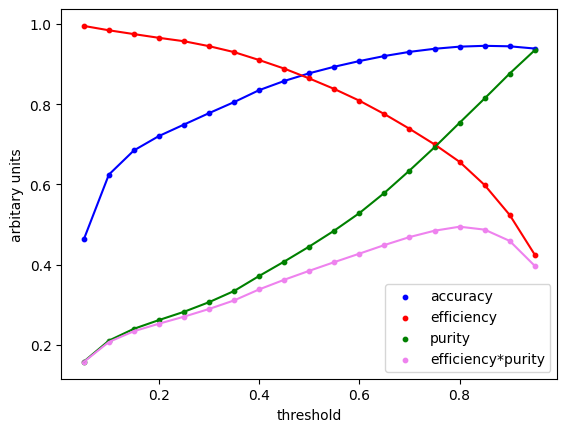

optimal_threshold: 0.8500000000000001
max_accuracy: 0.945444220230022
optimal_threshold_metric: 0.8
max_metric: 0.4945836855860666


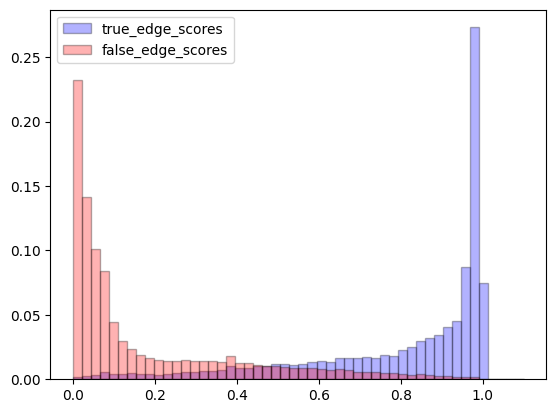

[0 0 0 ... 0 1 0]


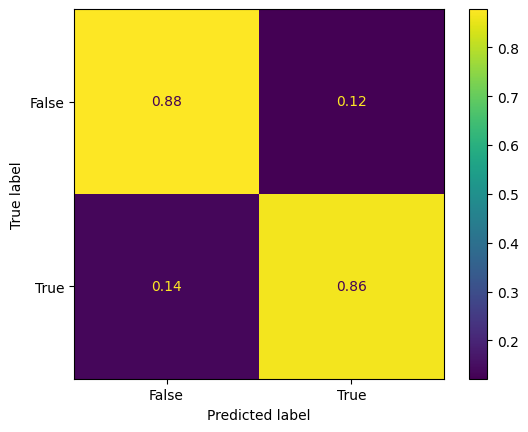

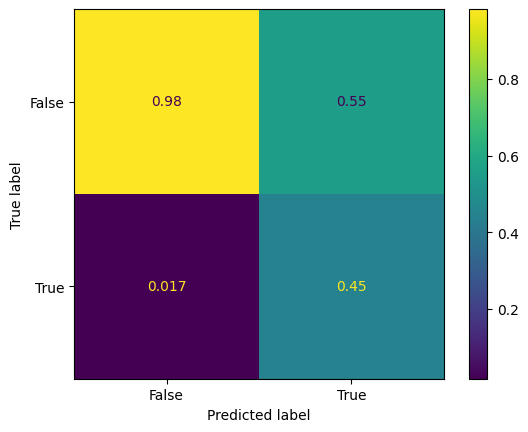

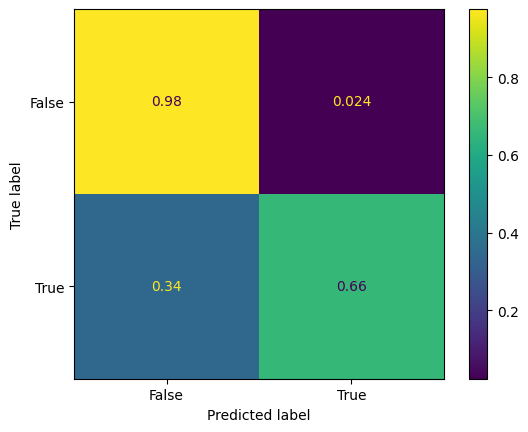

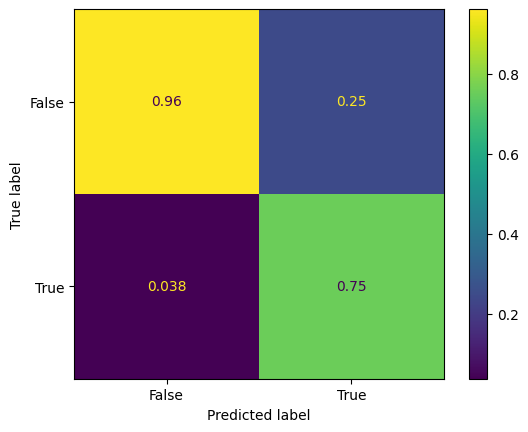

In [14]:
#######################################
# Run those functions!
#######################################

optimal_threshold, max_accuracy, optimal_threshold_metric, max_metric = calculate_accuracy(y_pred, y_test)

print('optimal_threshold:', optimal_threshold)
print('max_accuracy:', max_accuracy)
print('optimal_threshold_metric:', optimal_threshold_metric)
print('max_metric:', max_metric)

plot_scores(y_pred, y_test)
draw_confusion(y_pred, y_test)
draw_confusion_with_threshold(y_pred, y_test, optimal_threshold_metric)


In [15]:
###########################################################
# Let's look at the confusion matrix
###########################################################

